In [2]:
# when importing the new dataset, compare this one with median prices to the zillow estimate 

In [3]:
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import itertools

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm 

from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')

In [4]:
def stationarity_check(df):
    
#     roll_mean = df.rolling(window=12, center=False).mean()
#     roll_std = df.rolling(window=12,center=False).std()
    
    dftest = adfuller(df)
    
#     fig = plt.figure(figsize=(12,6))
#     plt.plot(df, color='blue',label='Original')
#     plt.plot(roll_mean, color='red', label='Rolling Mean')
#     plt.plot(roll_std, color='black', label='Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling mean and std')
#     plt.show(block=False)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value', '#lags used', 'number of observations used'])
    for k, v in dftest[4].items():
        dfoutput['Critical Value (%s)'%k] = v
    print(dfoutput)
    
    
def plot_residuals(model):
    residuals = pd.DataFrame(model.resid)
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    residuals.plot(title='Residuals', ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()

In [5]:
data = pd.read_csv('zillow_data.csv')

In [6]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [7]:
print(f'{data.RegionName.nunique()} unique zip codes')

print('{} unique zip codes in NJ'.format(data[data.State == 'NJ'].RegionName.nunique()))

14723 unique zip codes
502 unique zip codes in NJ


In [8]:
nj = data[data.State == 'NJ']
nj.isna().sum()
# null_values = pd.DataFrame(nj.isna().sum(), columns=['sum']).sort_values(by='sum', ascending=False)
# null_values

RegionID      0
RegionName    0
City          0
State         0
Metro         0
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int64

In [9]:
melted = pd.melt(nj,id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
len(melted) #502 zip codes in NJ and 1996 to 2018 
print(melted.isna().sum())
melted.head()

RegionName    0
RegionID      0
SizeRank      0
City          0
State         0
Metro         0
CountyName    0
time          0
value         0
dtype: int64


,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,7030,60545,58,Hoboken,NJ,New York,Hudson,1996-04-01,301600.0
1,8701,61148,74,Lakewood,NJ,New York,Ocean,1996-04-01,153800.0
2,8753,61169,159,Toms River,NJ,New York,Ocean,1996-04-01,123400.0
3,7002,60518,188,Bayonne,NJ,New York,Hudson,1996-04-01,145000.0
4,7302,60639,192,Jersey City,NJ,New York,Hudson,1996-04-01,137200.0


In [10]:
df = melted[['RegionName','time','value']].rename(columns={'RegionName':'zip','value':'median_price'}).set_index('time')
df.head()

,zip,median_price
time,,
1996-04-01,7030,301600.0
1996-04-01,8701,153800.0
1996-04-01,8753,123400.0
1996-04-01,7002,145000.0
1996-04-01,7302,137200.0


## Overall NJ Analysis 

In [11]:
nj_avg = df[['median_price']].groupby('time').median_price.median().reset_index().rename(columns={'median_price':'median_price'}).set_index('time')
nj_avg

,median_price
time,
1996-04-01,156650.0
1996-05-01,156650.0
1996-06-01,156600.0
1996-07-01,156550.0
1996-08-01,156450.0
...,...
2017-12-01,331650.0
2018-01-01,333050.0
2018-02-01,334100.0


<AxesSubplot:xlabel='time'>

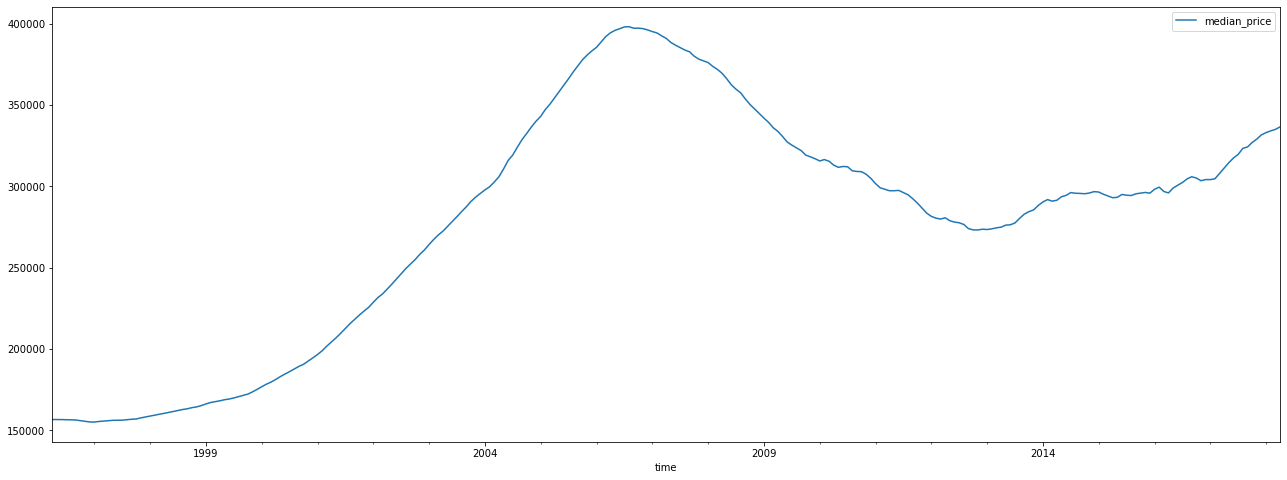

In [12]:
nj_avg.plot(figsize=(22,8))

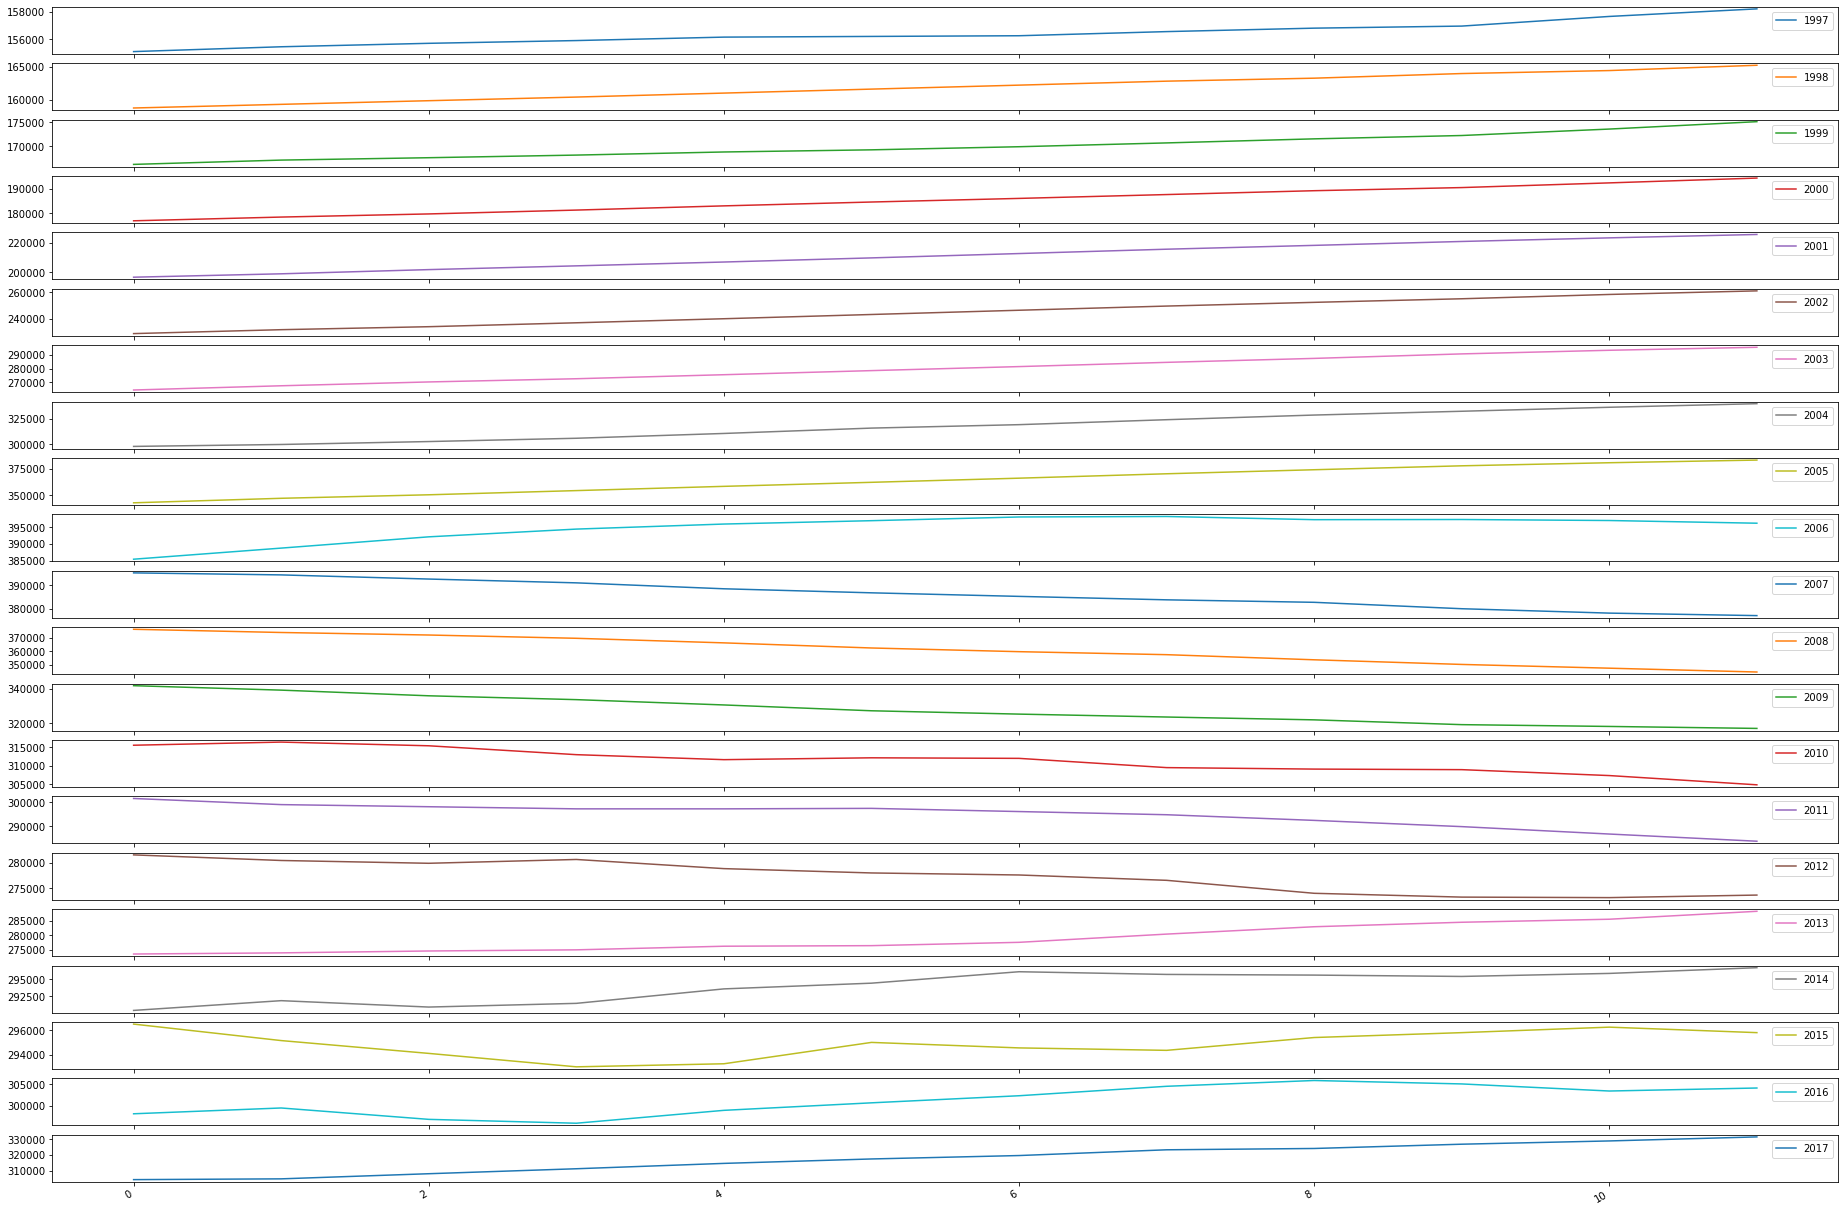

In [13]:
# not full years in 96 and 2018 
year_groups = nj_avg['1997':'2017'].groupby(pd.Grouper(freq='A'))
temp_annual = pd.DataFrame()
for yr, group in year_groups:
    temp_annual[yr.year] = group.values.ravel()
temp_annual.plot(figsize=(32,24),subplots=True, legend=True)
plt.show()

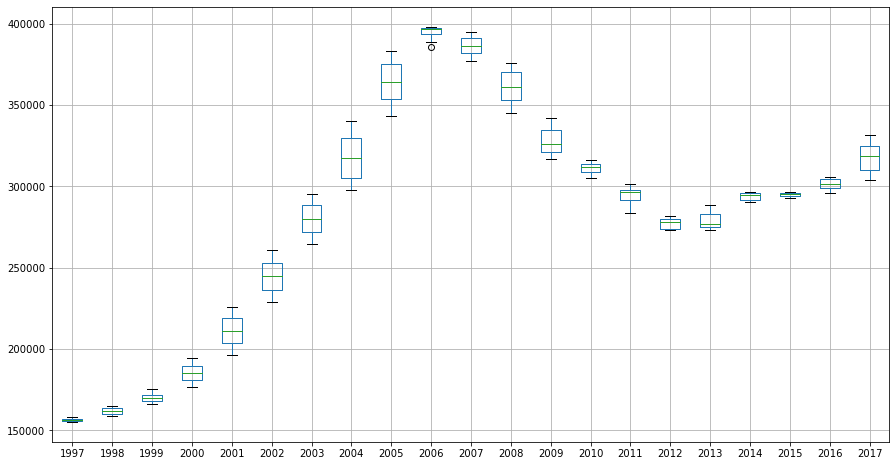

In [14]:
temp_annual.boxplot(figsize=(15,8))
plt.show()

In [15]:
nj_avg

,median_price
time,
1996-04-01,156650.0
1996-05-01,156650.0
1996-06-01,156600.0
1996-07-01,156550.0
1996-08-01,156450.0
...,...
2017-12-01,331650.0
2018-01-01,333050.0
2018-02-01,334100.0


In [16]:
nj_avg.diff(periods=1).bfill()

,median_price
time,
1996-04-01,0.0
1996-05-01,0.0
1996-06-01,-50.0
1996-07-01,-50.0
1996-08-01,-100.0
...,...
2017-12-01,2600.0
2018-01-01,1400.0
2018-02-01,1050.0


In [17]:
nj_avg.diff().diff().bfill()

,median_price
time,
1996-04-01,-50.0
1996-05-01,-50.0
1996-06-01,-50.0
1996-07-01,0.0
1996-08-01,-50.0
...,...
2017-12-01,500.0
2018-01-01,-1200.0
2018-02-01,-350.0


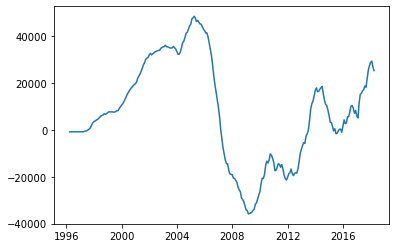

In [18]:
plt.plot(nj_avg.diff(periods=12).bfill())

In [19]:
stationarity_check(nj_avg.diff().diff().bfill())

Test Statistic                -9.794179e+00
p-value                        6.237826e-17
#lags used                     5.000000e+00
number of observations used    2.590000e+02
Critical Value (1%)           -3.455853e+00
Critical Value (5%)           -2.872765e+00
Critical Value (10%)          -2.572752e+00
dtype: float64


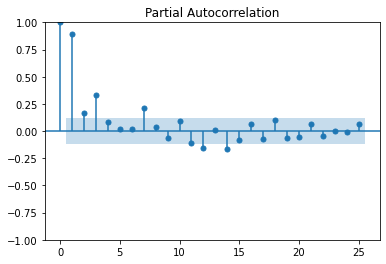

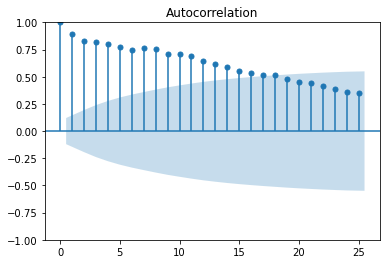

Second order differencing


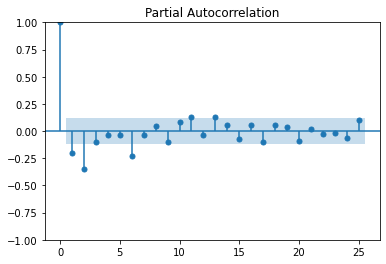

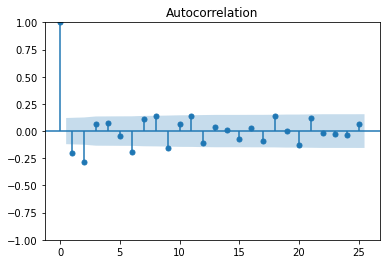

'Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. \nSo, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.\n\n'

In [20]:
plot_pacf(nj_avg.diff(periods=1).bfill())
plt.show()
plot_acf(nj_avg.diff(periods=1).bfill())
plt.show()
print('Second order differencing')
plot_pacf(nj_avg.diff().diff().bfill())
plt.show()
plot_acf(nj_avg.diff().diff().bfill())
plt.show()

"""Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. 
So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

"""

In [21]:
""" 
p=1 
d=2 
q=1 (slightly over differenced based on the immediate negative correlation for the acf plot)
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. 
Likewise, if it is slightly over-differenced, try adding an additional MA term.

"""

' \np=1 \nd=2 \nq=1 (slightly over differenced based on the immediate negative correlation for the acf plot)\nhttps://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/\nIf your series is slightly under differenced, adding one or more additional AR terms usually makes it up. \nLikewise, if it is slightly over-differenced, try adding an additional MA term.\n\n'

## Model Prototyping (Overall NJ prices) 

## Manual ARIMA Model (0,2,0)

In [22]:
# calculate RMSE on train data 
# one step forecast on test data 
# RMSE on test data
# then fit model with all data and make forecasts 

In [25]:
train = nj_avg.loc['2011':'2015-03-01']
test = nj_avg.loc['2015-04-01':]

                               SARIMAX Results                                
Dep. Variable:           median_price   No. Observations:                   51
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -412.153
Date:                Sat, 05 Mar 2022   AIC                            826.306
Time:                        11:00:07   BIC                            828.198
Sample:                    01-01-2011   HQIC                           827.024
                         - 03-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.183e+06   2.75e+05      4.295      0.000    6.43e+05    1.72e+06
Ljung-Box (L1) (Q):                   1.61   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.20   Pr

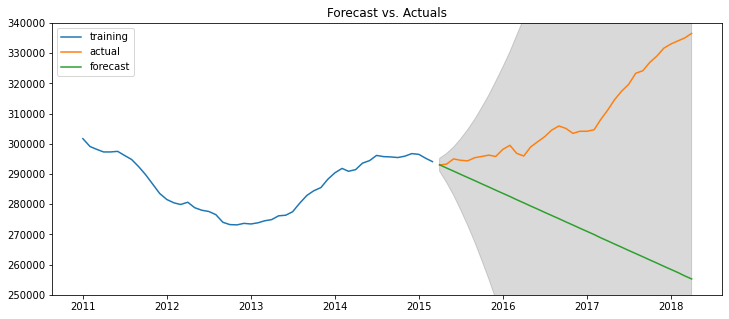

In [26]:
model = sm.tsa.statespace.SARIMAX(train, order=(0,2,0))
model_fit = model.fit()
print(model_fit.summary())

fc = model_fit.get_forecast(steps=len(test))
conf = fc.conf_int()
fc_series = model_fit.forecast(len(test))

lower_series = conf['lower median_price']
upper_series = conf['upper median_price']


plt.figure(figsize=(12,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Forecast vs. Actuals')
plt.ylim(250000,340000)
plt.legend()
plt.show()

In [28]:
print(f'RMSE: {np.sqrt(mean_squared_error(test, fc_series))}')

RMSE: 42577.8785667304


## Auto Arima

In [29]:
stationarity_check(nj_avg['2011':]['median_price'])

Test Statistic                  0.913342
p-value                         0.993262
#lags used                      1.000000
number of observations used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64


In [30]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(nj_avg['median_price'])

(0.38525676749450277, True)

In [33]:
train = nj_avg.loc['2011':'2015-03-01']
test = nj_avg.loc['2015-04-01':]

In [34]:
arima_model = auto_arima(train, start_p=0, start_d = 1, start_q = 0, max_p=5, 
                         max_d=5, max_q=5, start_P=0, start_D=0, start_Q=0, max_P=5, max_D=5, max_Q=5, 
                         m=12, seasonal=True, error_action='warn', trace=True, 
                         supress_warnings=True, stepwise=True, random_state=42, n_fits=1000)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1077.623, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=902.734, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1428.551, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=901.003, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=902.782, Time=0.06 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=900.452, Time=0.14 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=892.226, Time=0.75 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=890.363, Time=0.24 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=892.246, Time=1.19 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=894.222, Time=1.44 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1071.373, Time=0.35 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=864.618, Time=0.26 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1182.281, Time=0.37 sec
 ARIMA(2,0,0)(3,0,0)[12] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   51
Model:             SARIMAX(2, 0, 0)x(3, 0, 0, 12)   Log Likelihood                -425.209
Date:                            Sat, 05 Mar 2022   AIC                            864.419
Time:                                    11:27:47   BIC                            877.941
Sample:                                         0   HQIC                           869.586
                                             - 51                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6483.2652   2.09e-06    3.1e+09      0.000    6483.265    6483.265
ar.L1          1.6885      0.150     11.237      0.000       1.394       1.983
ar.L2         -0.7008      0.150     -4.660      0.000      -0.996      -0.406
ar.S.L12      -0.2140      0.233     -0.919      0.358      -0.671       0.243
ar.S.L24      -0.2765      0.217     -1.272      0.203      -0.702       0.149
ar.S.L36      -0.3291      0.261     -1.259      0.208      -0.841       0.183
sigma2      9.579e+05   2.37e-07   4.04e+12      0.000    9.58e+05    9.58e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.34   Prob(JB):                         0.70
Heteroskedasticity (H):               0.98   Skew:                            -0.05
Prob(H) (two-sided):                  0.96   Kurtosis:                         2.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.27e+28. Standard errors may be unstable.
"""

In [ ]:
len(test)

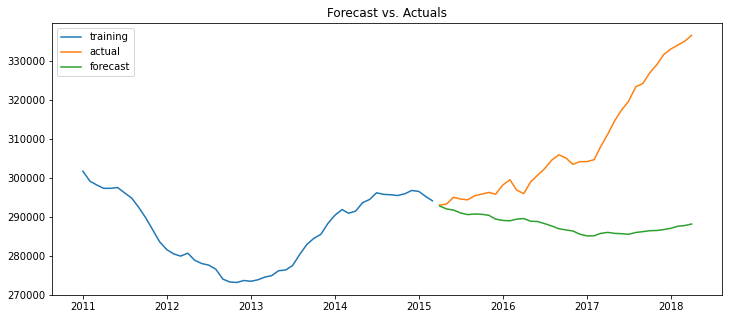

In [35]:
# TODO add confidence intervals 
prediction = pd.DataFrame(arima_model.predict(n_periods=37),index=test.index)
prediction.columns = ['median_price_predicted']

plt.figure(figsize=(12,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(prediction, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Forecast vs. Actuals')
plt.legend()
plt.show()

In [36]:
forecasted = prediction['median_price_predicted']
print(f'RMSE: {np.sqrt(mean_squared_error(forecasted, test))}')

RMSE: 25772.64686821556


## Goodness of fit with Auto ARIMA Model

In [158]:
mod = sm.tsa.statespace.SARIMAX(train, order=(2,0,0),seasonal_order=(3,0,0,12))
fit = mod.fit(disp=False)
predict=fit.get_prediction()
predict_ci = predict.conf_int()

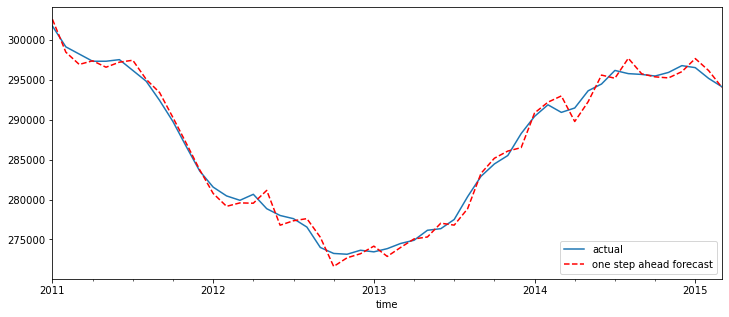

In [159]:
fig,ax=plt.subplots(figsize=(12,5))
train_data['2011':].plot(ax=ax, label='actual')
predict.predicted_mean.loc['2011':'2015-04-01'].plot(ax=ax, style='r--', label='one step ahead forecast')
# predict_dy.predicted_mean.loc['2014-01-01':].plot(ax=ax,style='g', label='Dynamic Forecast')
legend=ax.legend(loc='lower right')

In [160]:
actual = train_data['2011':]
forecasted = predict.predicted_mean.loc['2011':'2015-04-01']
print(f'RMSE: {np.sqrt(mean_squared_error(forecasted, actual))}')

RMSE: 1000.6189240837616


In [175]:
# get 
mod_test = sm.tsa.statespace.SARIMAX(nj_avg, order=(2,0,0),seasonal_order=(3,0,0,12))
res_test = mod_02.filter(fit.params)
predict_test = res_test.get_prediction()

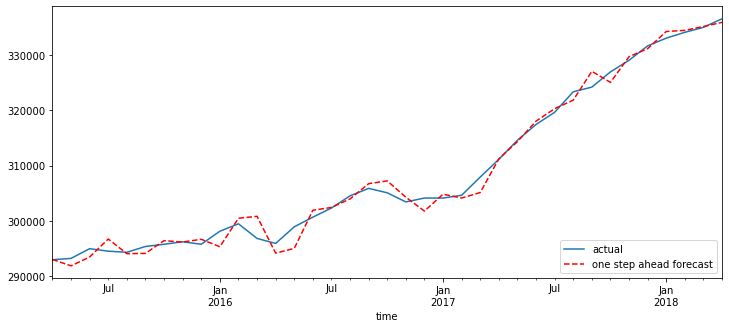

In [176]:
fig,ax=plt.subplots(figsize=(12,5))
test_data.plot(ax=ax, label='actual')
predict_test.predicted_mean.loc['2015-04-01':].plot(ax=ax, style='r--', label='one step ahead forecast')
legend=ax.legend(loc='lower right')

In [163]:
actual = test_data
forecasted = predict_test.predicted_mean.loc['2015-04-01':'2018-05-01']
print(f'RMSE: {np.sqrt(mean_squared_error(forecasted, actual))}')

RMSE: 1597.7179671892777


### Retrain on all data and then dynamic forecasting 

In [164]:
all_data = nj_avg.loc['1996':]['median_price']
all_data

time
1996-04-01    156650.0
1996-05-01    156650.0
1996-06-01    156600.0
1996-07-01    156550.0
1996-08-01    156450.0
                ...   
2017-12-01    331650.0
2018-01-01    333050.0
2018-02-01    334100.0
2018-03-01    335000.0
2018-04-01    336550.0
Name: median_price, Length: 265, dtype: float64

In [165]:
mod = sm.tsa.statespace.SARIMAX(all_data, order=(2,0,0),seasonal_order=(3,0,0,12))
fit_results = mod.fit()
print(fit_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       median_price   No. Observations:                  265
Model:             SARIMAX(2, 0, 0)x(3, 0, 0, 12)   Log Likelihood               -2188.764
Date:                            Fri, 04 Mar 2022   AIC                           4389.527
Time:                                    09:45:27   BIC                           4411.005
Sample:                                04-01-1996   HQIC                          4398.157
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9203      0.027     70.736      0.000       1.867       1.973
ar.L2         -0.9203      0.027   

In [166]:
# one step ahead 
predict=fit_results.get_prediction()
predict_ci = predict.conf_int()

# dynamic forecasts 
predict_dy = fit_res.get_prediction(dynamic='2014-03-01', full_results=True)
predict_dy_ci = predict_dy.conf_int()

In [167]:
forecasted = predict_dy.predicted_mean['2014-03-01':]
actual = all_data['2014-03-01':]
print(f'RMSE: {np.sqrt(mean_squared_error(forecasted, actual))}')

RMSE: 26138.35017746912


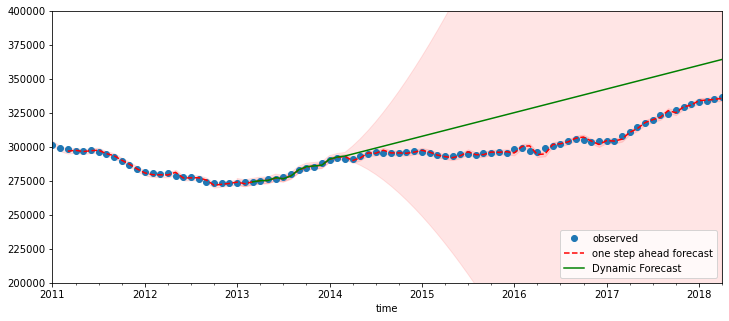

In [168]:
# plot actual, one step ahead and dynamic forecast 
fig,ax=plt.subplots(figsize=(12,5))
all_data.loc['2011':].plot(ax=ax, style='o', label='observed')

predict.predicted_mean.loc['2011-03-01':].plot(ax=ax, style='r--', label='one step ahead forecast')
ci = predict_ci.loc['2011':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

predict_dy.predicted_mean.loc['2013-03-01':].plot(ax=ax,style='g', label='Dynamic Forecast')
ci_dy = predict_dy_ci.loc['2013':]
ax.fill_between(ci_dy.index, ci_dy.iloc[:,0], ci_dy.iloc[:,1], color='r', alpha=0.1)

plt.ylim(200000, 400000)

legend=ax.legend(loc='lower right')

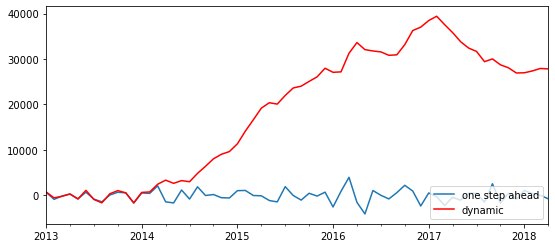

In [169]:
# Plot error 
fig,ax=plt.subplots(figsize=(9,4))

predict_error = predict.predicted_mean - all_data
predict_error.loc['2013':].plot(ax=ax, label='one step ahead')

predict_dy_error = predict_dy.predicted_mean - all_data
predict_dy_error.loc['2013':].plot(ax=ax, style='r', label='dynamic')

legend=ax.legend(loc='lower right')

### Rolling forecast 
https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70

In [ ]:
# split into train and test sets
# X = series.values
# size = int(len(X) * 0.66)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(5,1,0))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# rmse = sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % rmse)
# # plot forecasts against actual outcomes
# pyplot.plot(test)
# pyplot.plot(predictions, color='red')
# pyplot.show()

## Model Evaluation 

In [121]:
"""Around 2.2% MAPE implies the model is about 97.8% accurate in predicting the next 15 observations.
The other error metrics are quantities. That implies, an RMSE of 100 for a series whose 
mean is in 1000’s is better than an RMSE of 5 for series in 10’s. 
So, you can’t really use them to compare the forecasts of two different scaled time series.
"""

'Around 2.2% MAPE implies the model is about 97.8% accurate in predicting the next 15 observations.\nThe other error metrics are quantities. That implies, an RMSE of 100 for a series whose \nmean is in 1000’s is better than an RMSE of 5 for series in 10’s. \nSo, you can’t really use them to compare the forecasts of two different scaled time series.\n'

## Get top 25 zip codes 
* long term returns (top 200) 
* short term returns (top 100) 
* top median yearly returns (top 50) 
* lowest volatility / risk (top 25) 

In [18]:
data = pd.read_csv('zillow_data.csv')

def prep_df(data, state='NJ'):
    nj = data[data.State == 'NJ']
    melted = pd.melt(nj,id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    df = melted[['RegionName','time','value']].rename(columns={'RegionName':'zip','value':'median_price'}).set_index('time')
    return df
df = prep_df(data)

In [19]:
df.head()

,zip,median_price
time,,
1996-04-01,7030,301600.0
1996-04-01,8701,153800.0
1996-04-01,8753,123400.0
1996-04-01,7002,145000.0
1996-04-01,7302,137200.0


In [20]:
montville = df[df.zip==7058]

# Long term returns

## Total ROI

In [21]:
def get_roi(df, num):
    def roi(series):
        return series.iloc[-1] / series.iloc[0]
    zip_roi = df.groupby('zip').agg({'median_price':roi}).rename(columns={'median_price':'roi'}).reset_index().sort_values(by='roi', ascending=False)
    return zip_roi.iloc[:num,:], list(zip_roi.iloc[:num,:].zip.unique())

get_roi(df, 10)

(      zip        roi
 92   7302  10.403061
 23   7030   6.148210
 216  7756   5.418274
 191  7720   5.088816
 69   7086   4.926930
 352  8202   4.923441
 94   7306   4.896768
 95   7307   4.782152
 188  7717   4.754368
 368  8247   4.365571,
 [7302, 7030, 7756, 7720, 7086, 8202, 7306, 7307, 7717, 8247])

## Median annual ROI 

In [22]:
def get_annual_roi(df,num):
    
    def annual_roi(series):
        years = list(df.index.year.unique())
        annual_rois = []
        for index, year in enumerate(years):
            curr_index = int(index * 12) 
            if curr_index != 0:
                curr_year = series.iloc[curr_index]
                prev_year = series.iloc[curr_index - 12]
                annual_roi = curr_year / prev_year
                annual_rois.append(annual_roi)
        return np.median(annual_rois)

    zip_annual_roi = df.groupby('zip').agg({'median_price':annual_roi}).rename(columns={'median_price':'median_annual_roi'}).reset_index()
    return zip_annual_roi.iloc[:num,:], list(zip_annual_roi.iloc[:num,:].zip.unique())

get_annual_roi(df,10)[1]

[7001, 7002, 7003, 7004, 7005, 7006, 7008, 7009, 7010, 7011]

# Short Term Returns 

* 3 year investment returns 

In [23]:
def get_short_roi(df, time_horizon=3,num=10):
    
    def short_roi_calc(series):
        index = series.index[-1] - pd.Timedelta(days=(365*time_horizon))
        index = pd.Timestamp(year=index.year,month=index.month,day=1)
        return series.iloc[-1] / series[index]
   
    zip_roi = df.groupby('zip').agg({'median_price':short_roi_calc}).rename(columns={'median_price':f'{time_horizon}_year_roi'}).reset_index().sort_values(by=f'{time_horizon}_year_roi', ascending=False)

    return zip_roi.iloc[:num,:], list(zip_roi.iloc[:num,:].zip.unique())

get_short_roi(df, 3, 10)[1]

[7302, 7307, 7306, 7305, 7050, 7086, 7114, 7063, 7087, 8751]

# Risk/Volatility 

In [24]:
# lowest risk 
def get_volatility(df,num):
    
    def cv_calc(series):
        coef_variation = series.std() / series.mean()
        return coef_variation 
    
    result = df.groupby('zip').agg({'median_price':cv_calc}).reset_index().sort_values(by='median_price', ascending=True).rename(columns={'median_price':'cv'})
    return result.iloc[:num,:], list(result.iloc[:num,:].zip.unique())

get_volatility(df,10)[0]

,zip,cv
470,8833,0.195889
487,8867,0.197158
449,8801,0.197629
450,8802,0.199290
229,7830,0.201518
464,8826,0.203661
262,7931,0.203956
261,7930,0.203977
496,8886,0.204435
465,8827,0.204837


In [25]:
long_roi_zips = get_roi(df, 200)[1]
long_roi = df.loc[df['zip'].isin(long_roi_zips)]
print(long_roi['zip'].nunique())

short_roi_zips = get_short_roi(long_roi, 3, 100)[1]
short_roi = df.loc[df['zip'].isin(short_roi_zips)]
print(short_roi['zip'].nunique())

annual_roi_zips = get_annual_roi(short_roi,50)[1]
annual_roi = df.loc[df['zip'].isin(annual_roi_zips)]
print(annual_roi['zip'].nunique())

volatility_zips = get_volatility(annual_roi,25)[1]
volatility = df.loc[df['zip'].isin(volatility_zips)]
print(volatility['zip'].nunique())
print(volatility['zip'].unique())
volatility
# df = volatility(df,10)
# df

200
100
50
25
[7003 7601 7024 7052 7032 7110 7010 7424 7016 7071 7094 7070 7081 7020
 7066 7044 7057 7073 7075 7512 7033 7004 7072 7014 7088]


,zip,median_price
time,,
1996-04-01,7003,140800.0
1996-04-01,7601,157500.0
1996-04-01,7024,260200.0
1996-04-01,7052,165300.0
1996-04-01,7032,150300.0
...,...,...
2018-04-01,7033,361800.0
2018-04-01,7004,528600.0
2018-04-01,7072,404600.0


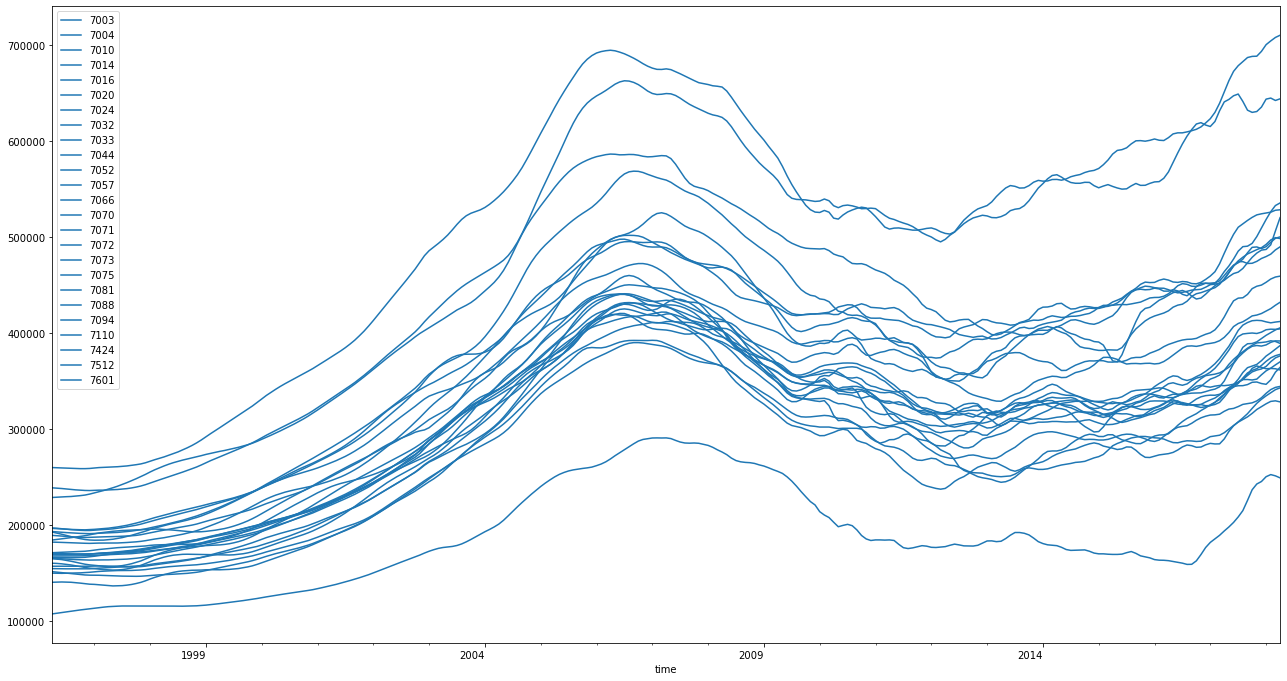

In [27]:
volatility.groupby('zip')['median_price'].plot(figsize=(22,13),subplots=True, legend=True)
plt.show()

In [28]:
top_25 = volatility.copy()
top_25 = top_25.reset_index().sort_values(by=['zip','time'])
top_25 = top_25.set_index('time')
# def monthly_roi_row(row):
#     curr_index = row.name
#     row['median_price'] 

top_25.head()

,zip,median_price
time,,
1996-04-01,7003,140800.0
1996-05-01,7003,141000.0
1996-06-01,7003,141100.0
1996-07-01,7003,141000.0
1996-08-01,7003,140800.0


In [139]:
""" For testing """
# west_orange = top_25[top_25.zip == 7052]
# west_orange['monthly_change'] = west_orange.median_price.pct_change()
# west_orange['monthly_change'].iloc[0] = 0.00

# jc = top_25[top_25.zip == 7003]
# jc['monthly_change'] = jc.median_price.pct_change()
# jc['monthly_change'].iloc[0] = 0.00

# print(265*2)
# combined = pd.concat([west_orange, jc])
# combined.iloc[265]

In [32]:
top_25_pct = pd.DataFrame()
for z in top_25.zip.unique():
    curr_df = top_25[top_25.zip == z]
    curr_df['monthly_change'] = curr_df.median_price.pct_change()
    curr_df['monthly_change'].iloc[0] = 0.00
    curr_df['roi_multiple'] = curr_df.median_price.pct_change() + 1.0
    curr_df['roi_multiple'].iloc[0] = 1.00
    
    top_25_pct = pd.concat([top_25_pct, curr_df])

print(len(top_25_pct))
print(len(top_25))

# rearrange so dataframe can be further analyzed 
# if sorted by zip then can't use time indexing 
top_25_pct = top_25_pct.reset_index().sort_values(by='time',ascending=True)
top_25_pct = top_25_pct.set_index('time')
top_25_pct.head(10)

6625
6625


,zip,median_price,monthly_change,roi_multiple
time,,,,
1996-04-01,7003,140800.0,0.0,1.0
1996-04-01,7016,197300.0,0.0,1.0
1996-04-01,7110,160600.0,0.0,1.0
1996-04-01,7024,260200.0,0.0,1.0
1996-04-01,7088,107900.0,0.0,1.0
1996-04-01,7033,155000.0,0.0,1.0
1996-04-01,7075,170700.0,0.0,1.0
1996-04-01,7512,166500.0,0.0,1.0
1996-04-01,7057,168100.0,0.0,1.0


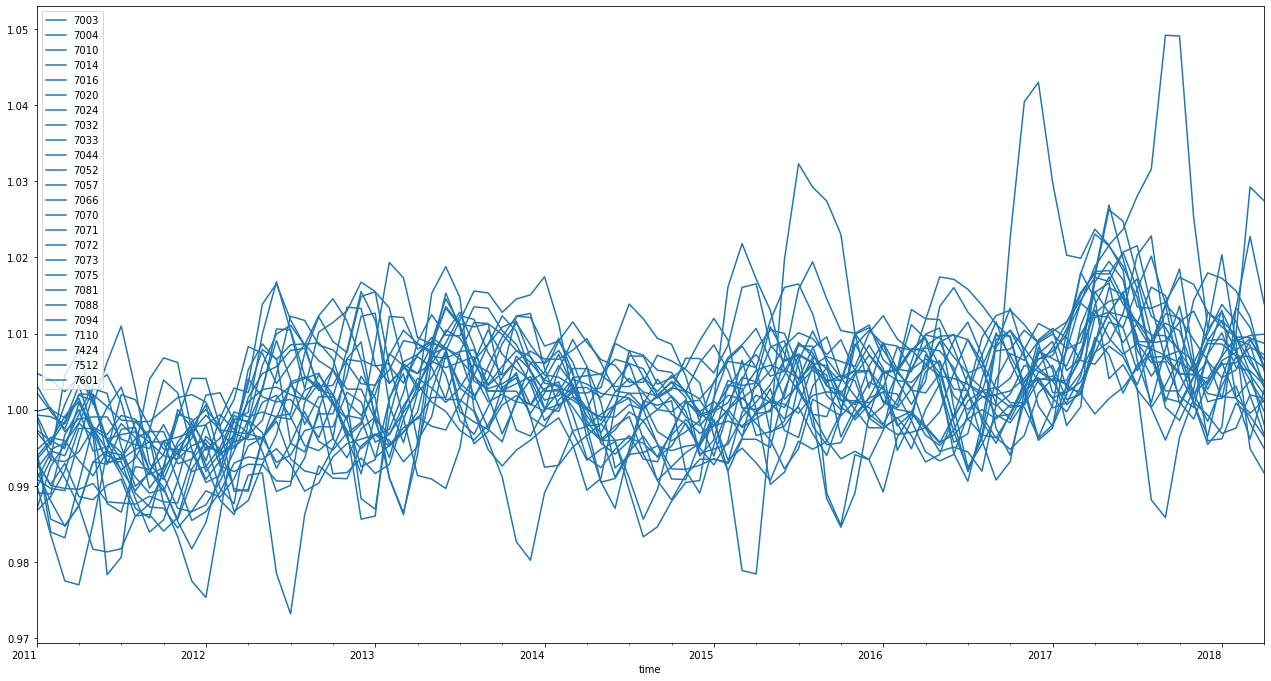

In [33]:
top_25_pct['2011':].groupby('zip')['roi_multiple'].plot(figsize=(22,13),subplots=True, legend=True)
plt.show()

<AxesSubplot:xlabel='time'>

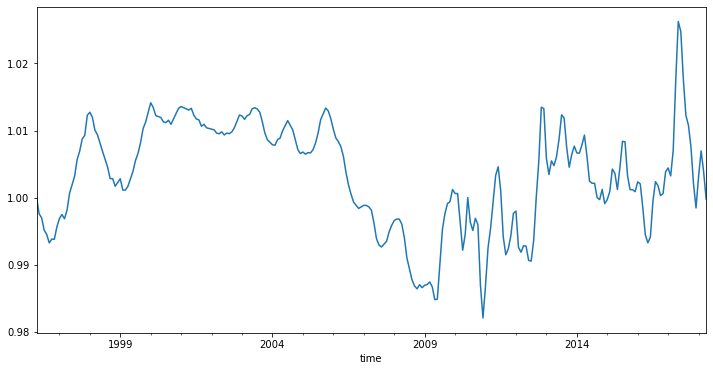

In [224]:
top_25_pct[top_25_pct.zip == 7052]['roi_multiple'].plot(figsize=(12,6))

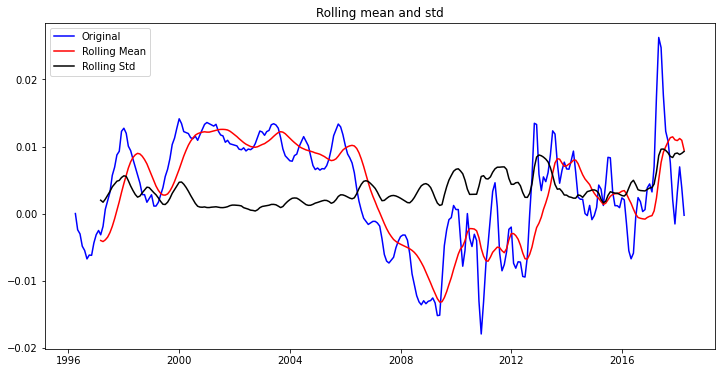

Test Statistic                  -1.450367
p-value                          0.557906
#lags used                      15.000000
number of observations used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [230]:
stationarity_check(top_25_pct[top_25_pct.zip == 7052]['monthly_change'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

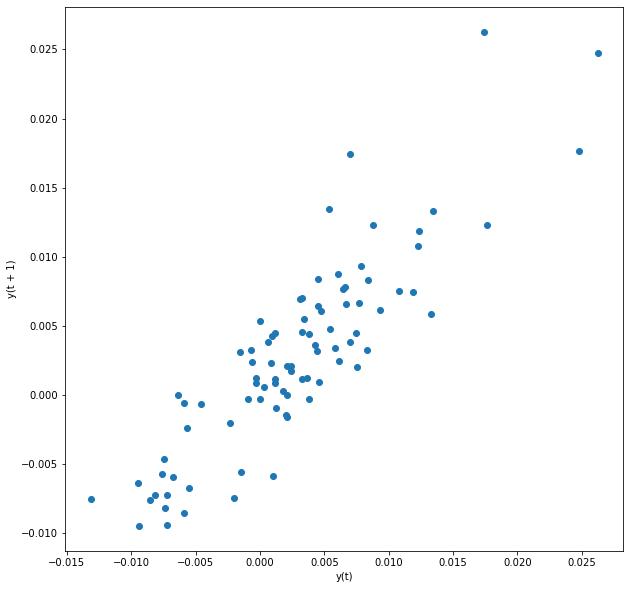

In [268]:
lag_plot(west_orange['2011':]['monthly_change'], lag=1)

In [ ]:
result_add = seasonal_decompose(nj_avg, model='additive', extrapolate_trend='freq')
result_mult = seasonal_decompose(nj_avg, model='multiplicative', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
result_mult.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

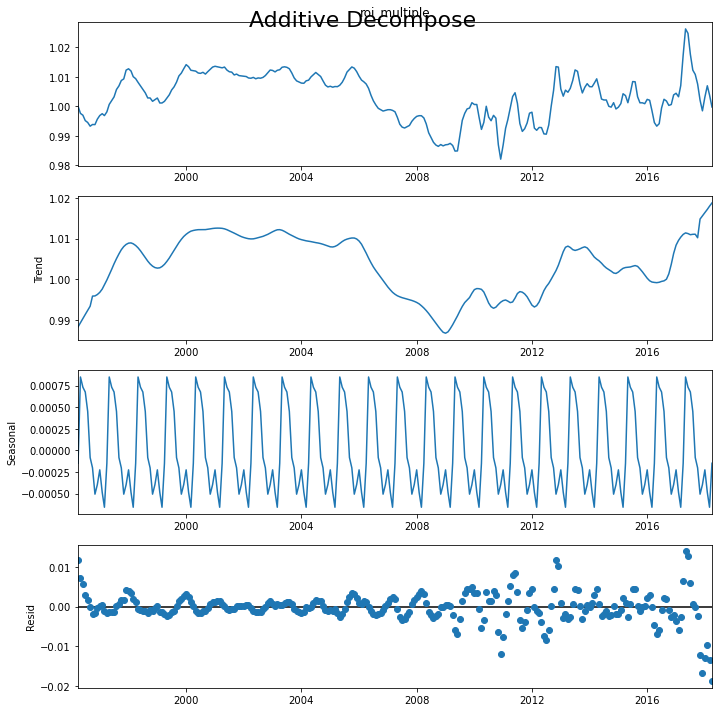

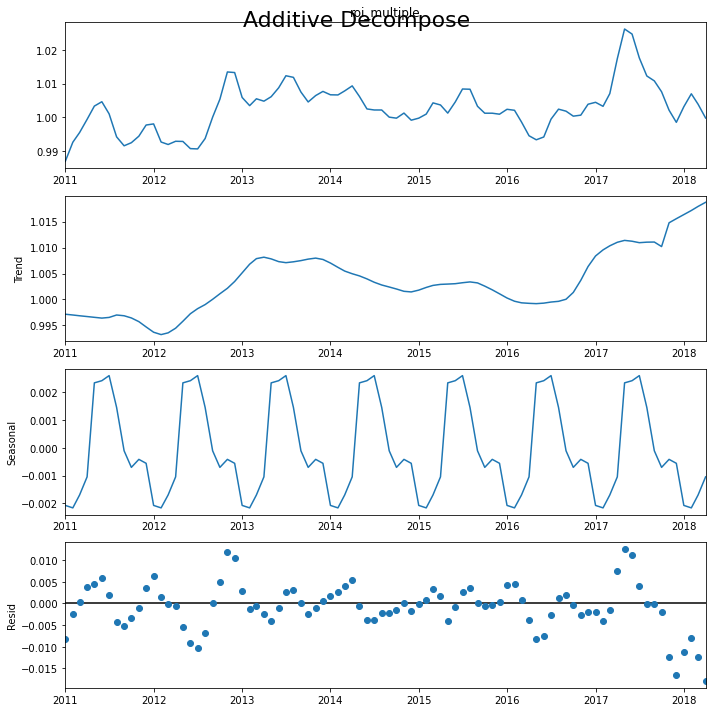

In [259]:
west_orange = top_25_pct[top_25_pct.zip == 7052]
result_add = seasonal_decompose(west_orange['2011':].roi_multiple, model='additive', extrapolate_trend='freq')
result_mult = seasonal_decompose(west_orange.roi_multiple, model='additive', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize': (10,10)})
result_mult.plot().suptitle('Additive Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

# Model prototyping

In [ ]:
# Notice the points fall along a line in the middle of the graph, 
# but curve off in the extremities. Normal Q-Q plots that exhibit this 
# behavior usually mean your data have more extreme values than would be expected if they truly came from a Normal distribution.
# https://data.library.virginia.edu/understanding-q-q-plots/
